In [ ]:
from openai import OpenAI
import pandas as pd
import os
import json
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Load the API key from your .env
load_dotenv(dotenv_path=".env")  # You can give it the path explicitly
# Define api_key first
api_key = os.getenv("OPENAI_API_KEY")

https://www.kaggle.com/datasets/nair26/predictive-maintenance-of-machines/data

In [2]:
print("Loaded API key:", os.getenv("OPENAI_API_KEY")[:8] + "..." if os.getenv("OPENAI_API_KEY") else "❌ Not loaded")

Loaded API key: sk-proj-...


In [21]:

# Load the CSV file
df = pd.read_csv('Data/maintenance.csv')

# Display the first few rows of the DataFrame
df.sample(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type
225,226,L47405,L,298.3,308.5,1362,53.8,34.279839,68.18,No Failure
411,412,L47591,L,297.5,308.7,1429,44.3,35.000000,134.13,No Failure
79,80,L47259,L,298.8,308.9,1402,37.9,55.000000,55.00,Tool Wear Failure
482,483,L47662,L,297.3,309.0,1548,37.4,37.000000,159.30,No Failure
275,276,L47455,L,298.0,308.0,1401,54.7,34.000000,85.91,No Failure
78,79,L47258,L,298.8,308.9,1398,51.5,45.000000,96.00,Tool Wear Failure
122,123,L47302,L,299.0,308.8,1310,50.7,24.000000,31.66,No Failure
384,385,L47564,L,297.5,308.5,1712,26.8,39.000000,124.55,No Failure
425,426,M15285,M,297.3,308.4,1665,28.9,32.309677,139.09,No Failure
294,295,M15154,M,298.1,308.5,1372,51.1,52.000000,92.65,No Failure


Cleaning the data

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      500 non-null    int64  
 1   Product ID               500 non-null    object 
 2   Type                     500 non-null    object 
 3   Air temperature [K]      500 non-null    float64
 4   Process temperature [K]  500 non-null    float64
 5   Rotational speed [rpm]   500 non-null    int64  
 6   Torque [Nm]              500 non-null    float64
 7   Vibration Levels         500 non-null    float64
 8   Operational Hours        500 non-null    float64
 9   Failure Type             500 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 39.2+ KB


In [5]:
df.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Vibration Levels           0
Operational Hours          0
Failure Type               0
dtype: int64

In [6]:
df.duplicated().sum()

np.int64(0)

In [7]:
df.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Vibration Levels           float64
Operational Hours          float64
Failure Type                object
dtype: object

In [8]:
# Removes any leading/trailing whitespace from column names to ensure consistent access
df.columns = df.columns.str.strip()


In [9]:
print(df.columns.tolist())


['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Vibration Levels', 'Operational Hours', 'Failure Type']


In [ ]:
# Creates a natural language prompt using engine sensor data for AI to return a JSON report

def create_prompt(row):
    return (
        f"You are a maintenance technician writing a short inspection report. "
        f"Based on the engine data below, respond in JSON format with two keys: "
        f"'comment' (a short summary in technician tone) and 'action' (a clear recommended action).\n\n"
        f"- Engine ID: {row['UDI']}\n"
        f"- Air temperature: {row['Air temperature [K]']} K\n"
        f"- Process temperature: {row['Process temperature [K]']} K\n"
        f"- Rotational speed: {row['Rotational speed [rpm]']} rpm\n"
        f"- Torque: {row['Torque [Nm]']} Nm\n"
        f"- Vibration level: {row['Vibration Levels']}\n"
        f"- Operational hours: {row['Operational Hours']}\n"
        f"- Failure Type: {row['Failure Type']}\n\n"
        f"Respond in this exact JSON format:\n"
        f'{{"comment": "...", "action": "..."}}'
    )


In [ ]:
# Sends prompt to AI and extracts 'comment' and 'action' from JSON response

def generate_maintenance_report(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
        max_tokens=800
    )
    
    raw_output = response.choices[0].message.content.strip()


    try:
        result = json.loads(raw_output)
        return result.get("comment", ""), result.get("action", "")
    except json.JSONDecodeError:
        return raw_output, "Unable to extract action"

In [13]:
#  Make a safe copy of the original dataframe

generate_maintenance_report_df = df.copy()


In [ ]:
# Wraps prompt/response pipeline with error handling for DataFrame row

def safe_llm_comment(row):
    try:
        return pd.Series(generate_maintenance_report(create_prompt(row)))
    except Exception as e:
        print(f"Error on row {row['UDI']}: {e}")
        return pd.Series(["LLM error", "Unable to generate action"])


In [15]:
# Apply the LLM prompt and response function to each row of the dataset.
# For every row, it generates a structured JSON response from the model,
# then extracts and stores the 'comment' and 'recommended action' into two new columns.

generate_maintenance_report_df[["Inspection Summary", "Recommended Action"]] = generate_maintenance_report_df.apply(
    safe_llm_comment,
    axis=1
)




In [16]:
generate_maintenance_report_df.sample(5)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type,Inspection Summary,Recommended Action
240,241,M15100,M,298.0,308.1,1339,51.6,30.058065,73.50,No Failure,Engine 241 is operating within normal paramete...,Continue regular monitoring and schedule the n...
286,287,L47466,L,298.2,308.3,1589,33.2,34.000000,89.81,No Failure,Engine ID 287 is operating within normal param...,Monitor vibration levels during next inspectio...
75,76,L47255,L,298.8,308.9,1379,46.7,36.000000,84.00,Tool Wear Failure,Engine 76 shows signs of tool wear failure wit...,Schedule maintenance to inspect and replace wo...
449,450,L47629,L,297.6,308.7,1622,37.9,25.554839,147.60,No Failure,Engine ID 450 is operating within normal param...,Monitor vibration levels and schedule a follow...
472,473,M15332,M,297.4,309.0,1497,41.8,55.000000,155.75,No Failure,Engine ID 473 is operating within normal param...,Monitor vibration levels during next inspectio...


In [36]:
generate_maintenance_report_df.to_csv("Data/generate_maintenance_report.csv", index=False)

In [37]:
#check the CSV
generate_maintenance_report_df.sample(5)[["UDI", "Inspection Summary", "Recommended Action"]]


,UDI,Inspection Summary,Recommended Action
58,59,Engine ID 59 is operating within normal parame...,Monitor vibration levels and schedule a follow...
222,223,Engine ID 223 is operating within normal param...,Continue regular monitoring and schedule next ...
203,204,Engine ID 204 is operating within normal param...,Monitor vibration levels during next inspectio...
215,216,Engine ID 216 is operating within normal param...,Continue regular monitoring and schedule next ...
354,355,Engine ID 355 is operating within normal param...,Continue regular monitoring and schedule next ...


In [ ]:
# Maps raw action text into standardized maintenance categories

def bucket_action(text):
    text = text.lower()
    if "no action" in text or "stable" in text:
        return "No Action"
    elif "monitor" in text:
        return "Monitor"
    elif any(term in text for term in ["inspection", "follow-up", "review", "diagnostics", "replace","faliure"]):
        return "Flag for Inspection"
    else:
        return "Flag for Inspection"


generate_maintenance_report_df["Action Category"] = generate_maintenance_report_df["Recommended Action"].apply(bucket_action)
generate_maintenance_report_df["Action Category"].value_counts()


Action Category
Monitor                468
Flag for Inspection     32
Name: count, dtype: int64

In [39]:
generated_action_df= generate_maintenance_report_df.copy() 

In [40]:
generated_action_df.sample(10) 

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type,Inspection Summary,Recommended Action,Action Category
357,358,L47537,L,297.6,308.4,1517,34.2,44.000000,114.98,No Failure,Engine ID 358 is operating within normal param...,Continue regular monitoring and maintenance sc...,Monitor
76,77,L47256,L,298.8,308.9,1461,47.9,33.000000,47.00,Tool Wear Failure,Engine ID 77 shows signs of tool wear failure ...,Schedule a maintenance check to assess and rep...,Flag for Inspection
292,293,L47472,L,298.1,308.4,1335,40.2,40.000000,91.94,No Failure,Engine ID 293 is operating within normal param...,Continue regular monitoring and maintenance sc...,Monitor
274,275,L47454,L,298.1,308.0,1652,28.5,34.000000,85.55,No Failure,Engine ID 275 is operating within normal param...,Monitor vibration levels during next inspectio...,Monitor
215,216,L47395,L,298.3,308.6,1548,40.3,24.000000,64.64,No Failure,Engine ID 216 is operating within normal param...,Continue regular monitoring and schedule next ...,Monitor
176,177,L47356,L,298.2,308.1,1618,34.7,23.000000,50.81,No Failure,Engine ID 177 is operating within normal param...,Continue regular monitoring and schedule next ...,Monitor
159,160,L47339,L,298.4,308.2,1471,47.0,38.000000,44.78,No Failure,Engine ID 160 is operating within normal param...,Continue regular monitoring and maintenance sc...,Monitor
56,57,L47236,L,298.8,309.1,1477,42.4,27.525000,58.00,No Failure,Engine ID 57 is operating within normal parame...,Monitor vibration levels and schedule a follow...,Monitor
138,139,H29552,H,298.8,308.6,1449,49.4,33.000000,37.34,No Failure,Engine ID 139 is operating within normal param...,Continue regular monitoring and schedule next ...,Monitor
426,427,L47606,L,297.4,308.5,1501,44.9,32.028226,139.45,No Failure,Engine 427 is operating within normal paramete...,Continue regular monitoring and maintenance sc...,Monitor


In [41]:
generated_action_df.to_csv("Data/generated_comments_with_actions.csv", index=False)

In [42]:
generated_action_df[generated_action_df["Failure Type"] != "No Failure"]


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Vibration Levels,Operational Hours,Failure Type,Inspection Summary,Recommended Action,Action Category
50,51,L47230,L,298.9,309.1,2861,4.6,29.213710,48.00,Power Failure,Engine ID 51 shows signs of power failure with...,Conduct a thorough inspection and diagnostics ...,Flag for Inspection
69,70,L47249,L,298.9,309.0,1410,65.7,42.000000,47.00,Power Failure,Engine ID 70 is experiencing a power failure w...,Conduct a detailed inspection of the engine co...,Flag for Inspection
73,74,L47253,L,299.0,309.1,1592,35.0,44.000000,55.00,Tool Wear Failure,Engine ID 74 shows signs of tool wear failure ...,Schedule a maintenance check to assess and rep...,Flag for Inspection
74,75,L47254,L,298.9,309.0,1601,32.3,35.000000,57.00,Tool Wear Failure,Engine ID 75 shows signs of tool wear failure ...,Schedule maintenance to inspect and replace wo...,Flag for Inspection
75,76,L47255,L,298.8,308.9,1379,46.7,36.000000,84.00,Tool Wear Failure,Engine ID 76 shows signs of tool wear failure ...,Schedule maintenance to inspect and replace wo...,Flag for Inspection
76,77,L47256,L,298.8,308.9,1461,47.9,33.000000,47.00,Tool Wear Failure,Engine ID 77 shows signs of tool wear failure ...,Schedule a maintenance check to assess and rep...,Flag for Inspection
77,78,L47257,L,298.8,308.9,1455,41.3,23.000000,56.00,Tool Wear Failure,Engine ID 78 shows signs of tool wear failure ...,Schedule immediate maintenance to inspect and ...,Flag for Inspection
78,79,L47258,L,298.8,308.9,1398,51.5,45.000000,96.00,Tool Wear Failure,Engine 79 shows signs of tool wear failure wit...,Schedule immediate inspection and replacement ...,Flag for Inspection
79,80,L47259,L,298.8,308.9,1402,37.9,55.000000,55.00,Tool Wear Failure,Engine ID 80 shows signs of tool wear failure ...,Schedule immediate inspection and replacement ...,Flag for Inspection
160,161,L47340,L,298.4,308.2,1282,60.7,39.000000,45.14,Overstrain Failure,Engine ID 161 shows signs of overstrain failur...,Conduct a thorough inspection of the engine co...,Flag for Inspection


In [ ]:
# Maps failure types to expected action categories to serve as ground truth

def map_failure_to_category(failure_type):
    if str(failure_type).lower() == "no failure":
        return "Monitor"
    else:
        return "Flag for Inspection"

generated_action_df["Expected Action Category"] = generated_action_df["Failure Type"].apply(map_failure_to_category)


In [44]:
generated_action_df["LLM Correct?"] = (
    generated_action_df["Action Category"].str.lower() == 
    generated_action_df["Expected Action Category"].str.lower()
)

accuracy = generated_action_df["LLM Correct?"].mean()
print(f"LLM Action Accuracy: {accuracy:.2%}")


LLM Action Accuracy: 99.80%


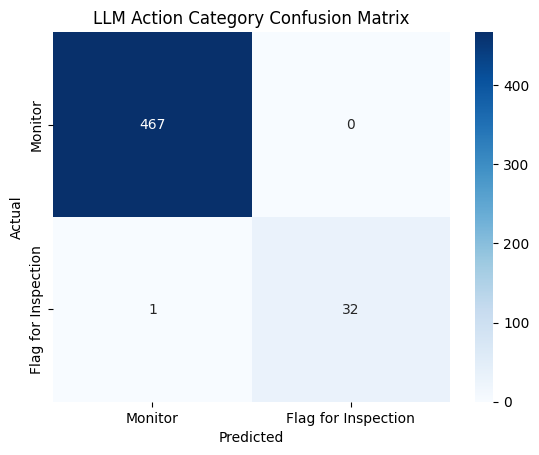

In [ ]:
#Confusion Matrix
# # True and predicted labels
y_true = generated_action_df["Expected Action Category"]
y_pred = generated_action_df["Action Category"]

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["Monitor", "Flag for Inspection"])

# Plot it
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Monitor", "Flag for Inspection"],
            yticklabels=["Monitor", "Flag for Inspection"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LLM Action Category Confusion Matrix")
plt.show()

In [ ]:
#Evaluate classification report
print(classification_report(y_true, y_pred, digits=3))


                     precision    recall  f1-score   support

Flag for Inspection      1.000     0.970     0.985        33
            Monitor      0.998     1.000     0.999       467

           accuracy                          0.998       500
          macro avg      0.999     0.985     0.992       500
       weighted avg      0.998     0.998     0.998       500



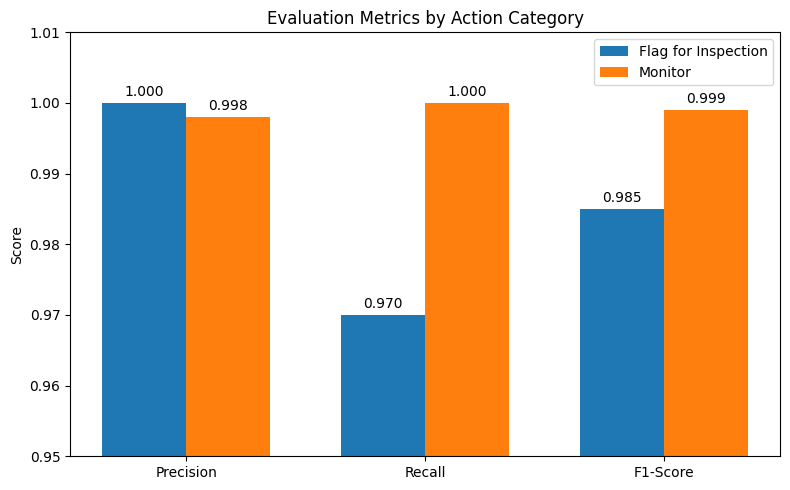

In [51]:
# Define the metrics and values
categories = ["Flag for Inspection", "Monitor"]
metrics = ["Precision", "Recall", "F1-Score"]

# Use your actual model results
values = {
    "Precision": [1.000, 0.998],
    "Recall": [0.970, 1.000],
    "F1-Score": [0.985, 0.999]
}

x = np.arange(len(metrics))  # Metric positions
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, [values[m][0] for m in metrics], width, label=categories[0], color="#1f77b4")
bar2 = ax.bar(x + width/2, [values[m][1] for m in metrics], width, label=categories[1], color="#ff7f0e")

# Add metric labels and values
ax.set_ylabel("Score")
ax.set_title("Evaluation Metrics by Action Category")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0.95, 1.01)
ax.legend()

# Annotate bar values
for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.3f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()